# Run simulation 

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from utils.array_to_df import using_multiindex

# Parameters
G = 5  # Number of generations
N_gen = 8  # Number of agents per generation
N_mach = 3  # Number of machines
P_ind = 2  # Number of problems for individual learning
P_soc = 4  # Number of problems for social learning
P_tot = P_ind + 2*P_soc  # Total number of problems
R_myopic = 1400  # Base reward for myopic solution
R_optimal = 2200  # Base reward for optimal solution
R_random = 600  # Base reward for random solutions
sigma = 200  # Standard deviation for Gaussian noise
d_myopic = 0.4  # Discoverability rate for myopic solutions
# d_optimal = 0.0001  # Discoverability rate for optimal solutions
# l_myopic = 0.11 # Learnability (probability of imitating the myopic solution)
# l_optimal = 0.11  # Learnability (probability of imitating the optimal solution)
machine_discovery_factor = 3  # Factor for the discovery rate of machines (order of magnitude)
epsilon = 0.5 # Probability of random exploration
K = 5  # Number of agents observed during social learning
M_ = 100  # Number of replications of the simulation


d_optimal_log_ = np.linspace(0, -6, 25)
d_optimal_ = np.power(10, d_optimal_log_)

l_optimal_ = np.linspace(0.0, 0.35, 25)
conditions_ = ['human', 'human-machine']

conditions = []
l_optimal = []
d_optimal_log = []
d_optimal = []
for c in conditions_:
    for d, d_log in zip(d_optimal_, d_optimal_log_):
        for l in l_optimal_:
            for m in range(M_):
                conditions.append(c)
                d_optimal.append(d)
                l_optimal.append(l)
                d_optimal_log.append(d_log)

conditions = np.array(conditions)
d_optimal_ = np.array(d_optimal)
l_optimal = np.array(l_optimal)
d_optimal_log = np.array(d_optimal_log)
d_myopic = np.ones_like(d_optimal) * d_myopic
l_myopic = l_optimal

M = len(conditions)

d_optimal = np.tile(d_optimal, (G, N_gen, 1)).transpose((2, 0, 1))

In [16]:
# Initialize agent preferences and exploration parameters
agent_prefs = np.ones((M, G, N_gen, P_tot), dtype=int) * -1 # 0: myopic, 1: optimal

is_machine = np.zeros((M, G, N_gen), dtype=bool)
is_machine[conditions == 'human-machine',0,:N_mach] = True

d_optimal[is_machine] = d_optimal[is_machine] * 10**machine_discovery_factor

# set machine preferences
# agent_prefs[conditions == 'human-machine', 0, :N_mach, :] = 1
solution_types = np.zeros((M, G, N_gen, P_tot), dtype=int)  # -1: random, 0: myopic, 1: optimal
rewards = np.zeros((M, G, N_gen, P_tot))
demo_solution_types = np.zeros((M, G, N_gen, P_tot), dtype=int)


def get_reward(solution_type):
    # Determine the base reward for each solution type
    is_myopic = solution_type == 0
    is_optimal = solution_type == 1
    base_reward = np.where(is_myopic, R_myopic, np.where(is_optimal, R_optimal, R_random))
    # Add Gaussian noise to the base reward
    noise = np.random.normal(0, sigma, size=base_reward.shape)
    return base_reward + noise

def solve_problem(agent_pref, d_myopic, d_optimal, allow_exploration=True):
    if allow_exploration:
        # Determine whether each agent explores or exploits
        explore = (np.random.rand(M, N_gen) < epsilon) & (agent_pref != 1)

        # Randomly discover the optimal solution during exploration
        discovered_myopic = (np.random.rand(M, N_gen) < d_myopic) & explore
        discovered_optimal = (np.random.rand(M, N_gen) < d_optimal) & explore
        random_solution = explore & (discovered_myopic | discovered_optimal)

        # Update agent preferences when discovered optimal solution
        agent_pref = np.where(discovered_myopic, 0, agent_pref)
        agent_pref = np.where(discovered_optimal, 1, agent_pref)

    solution_types = agent_pref.copy()

    if allow_exploration:
        # Update solution types for random exploration
        solution_types[random_solution] = -1

    rewards = get_reward(solution_types)
    return agent_pref, solution_types, rewards


def get_demo_solution_types(prev_rewards, prev_solution_types):
    avg_prev_reward = prev_rewards[:,:,-P_soc:].mean(axis=2) # Average reward for each agent over the last P_soc problems
    demo_solution_types = np.zeros((M, N_gen, P_tot), dtype=int) # Solution types passed from teachers to students
    for m in range(prev_rewards.shape[0]): # For each replication
        for n in range(prev_rewards.shape[1]): # For each agent
            random_k_possible_teacher = np.random.choice(N_gen, K, replace=False) # Randomly select K possible teachers
            teacher_indices = np.argmax(avg_prev_reward[m, random_k_possible_teacher]) # Select the teacher with the highest average reward
            teacher_indices = random_k_possible_teacher[teacher_indices] # Retrieve the teacher's index
            demo_solution_types[m, n] = prev_solution_types[m, teacher_indices] # Pass the teacher's solution types to the student
    return demo_solution_types


def social_learning(agent_pref, demo_solution_type):
    learned_optimal = (np.random.rand(M, N_gen) < l_optimal[:,np.newaxis]) & (demo_solution_type == 1)
    learned_myopic = (np.random.rand(M, N_gen) < l_myopic[:,np.newaxis]) & (demo_solution_type == 0)

    # Update agent preferences when discovered optimal solution
    agent_pref = np.where(learned_myopic & (agent_pref != 1), 0, agent_pref)
    agent_pref = np.where(learned_optimal, 1, agent_pref)

    return agent_pref


for g in range(G):
    if g > 0:
        demo_solution_types[:,g] = get_demo_solution_types(rewards[:,g-1], solution_types[:,g-1])
    for p in range(P_tot):
        is_individual_learning = (g > 0 and p < P_ind) or (g == 0 and p < P_ind + P_soc)
        is_social_learning = g > 0 and p >= P_ind and p < P_ind + P_soc
        is_demo = p >= P_ind + P_soc
        if is_social_learning:
            agent_prefs[:,g,:,p] = social_learning(agent_prefs[:,g,:,p], demo_solution_types[:,g,:,p+4])
        agent_prefs[:,g,:,p], solution_types[:,g,:,p], rewards[:,g,:,p] = solve_problem(
            agent_prefs[:,g,:,p], d_myopic[:,np.newaxis], d_optimal[:,g], allow_exploration=not is_demo)
        if p < P_tot - 1:
            agent_prefs[:, g, :, p + 1] = agent_prefs[:, g, :, p]


In [17]:
rewards_df = using_multiindex(rewards, ['rep', 'gen', 'agent', 'problem'])
agent_prefs_df = using_multiindex(agent_prefs, ['rep', 'gen', 'agent', 'problem'])
solution_types_df = using_multiindex(solution_types, ['rep', 'gen', 'agent', 'problem'])
demo_solution_types_df = using_multiindex(demo_solution_types, ['rep', 'gen', 'agent', 'problem'])

problem_types = {"individual": list(range(P_ind)), "social": list(range(P_ind, P_ind + P_soc)), "demo": list(range(P_ind + P_soc, P_tot))}
problem_types_map = {p_id: p_name for p_name, p_ids in problem_types.items() for p_id in p_ids}

rep_map = pd.DataFrame({
    'rep': np.arange(M),
    'condition': conditions,
    'd_optimal': d_optimal_,
    'l_optimal': l_optimal,
    'd_optimal_log': d_optimal_log,
    'd_myopic': d_myopic,
    'l_myopic': l_myopic
})


rewards_df['problem_type'] = rewards_df['problem'].map(problem_types_map)
agent_prefs_df['problem_type'] = agent_prefs_df['problem'].map(problem_types_map)
solution_types_df['problem_type'] = solution_types_df['problem'].map(problem_types_map)
demo_solution_types_df['problem_type'] = demo_solution_types_df['problem'].map(problem_types_map)

rewards_df = rewards_df.merge(rep_map, on='rep')
agent_prefs_df = agent_prefs_df.merge(rep_map, on='rep')
solution_types_df = solution_types_df.merge(rep_map, on='rep')
demo_solution_types_df = demo_solution_types_df.merge(rep_map, on='rep')

rewards_df['is_machine'] = (rewards_df['condition'] == 'human-machine') & (rewards_df['agent'] <= N_mach) & (rewards_df['gen'] == 0)
agent_prefs_df['is_machine'] = (agent_prefs_df['condition'] == 'human-machine') & (agent_prefs_df['agent'] <= N_mach) & (agent_prefs_df['gen'] == 0)
solution_types_df['is_machine'] = (solution_types_df['condition'] == 'human-machine') & (solution_types_df['agent'] <= N_mach) & (solution_types_df['gen'] == 0)
demo_solution_types_df['is_machine'] = (demo_solution_types_df['condition'] == 'human-machine') & (demo_solution_types_df['agent'] <= N_mach) & (demo_solution_types_df['gen'] == 0)

rewards_df.to_parquet('data/simulation/abm_v1/rewards.parquet')
agent_prefs_df.to_parquet('data/simulation/abm_v1/agent_prefs.parquet')
solution_types_df.to_parquet('data/simulation/abm_v1/solution_types.parquet')
demo_solution_types_df.to_parquet('data/simulation/abm_v1/demo_solution_types.parquet')

# Analysis

In [29]:
rewards_df = pd.read_parquet('data/simulation/abm_v1/rewards.parquet')
agent_prefs_df = pd.read_parquet('data/simulation/abm_v1/agent_prefs.parquet')
solution_types_df = pd.read_parquet('data/simulation/abm_v1/solution_types.parquet')
demo_solution_types_df = pd.read_parquet('data/simulation/abm_v1/demo_solution_types.parquet')

In [30]:
last_gen = rewards_df['gen'] == G - 1
demo = rewards_df['problem_type'] == 'demo'

df = rewards_df[last_gen & demo]

reward_matrix = df.pivot_table(index=['condition', 'l_optimal'], columns='d_optimal_log', values='value')
reward_diff_matrix = reward_matrix.loc['human-machine'] - reward_matrix.loc['human']


first_gen = rewards_df['gen'] == 0
demo = rewards_df['problem_type'] == 'demo'
is_machine = rewards_df['is_machine']
is_hybrid = rewards_df['condition'] == 'human-machine'

df = rewards_df[first_gen & demo & is_machine & is_hybrid]

machine_reward_matrix = df.pivot_table(index=['l_optimal'], columns='d_optimal_log', values='value')


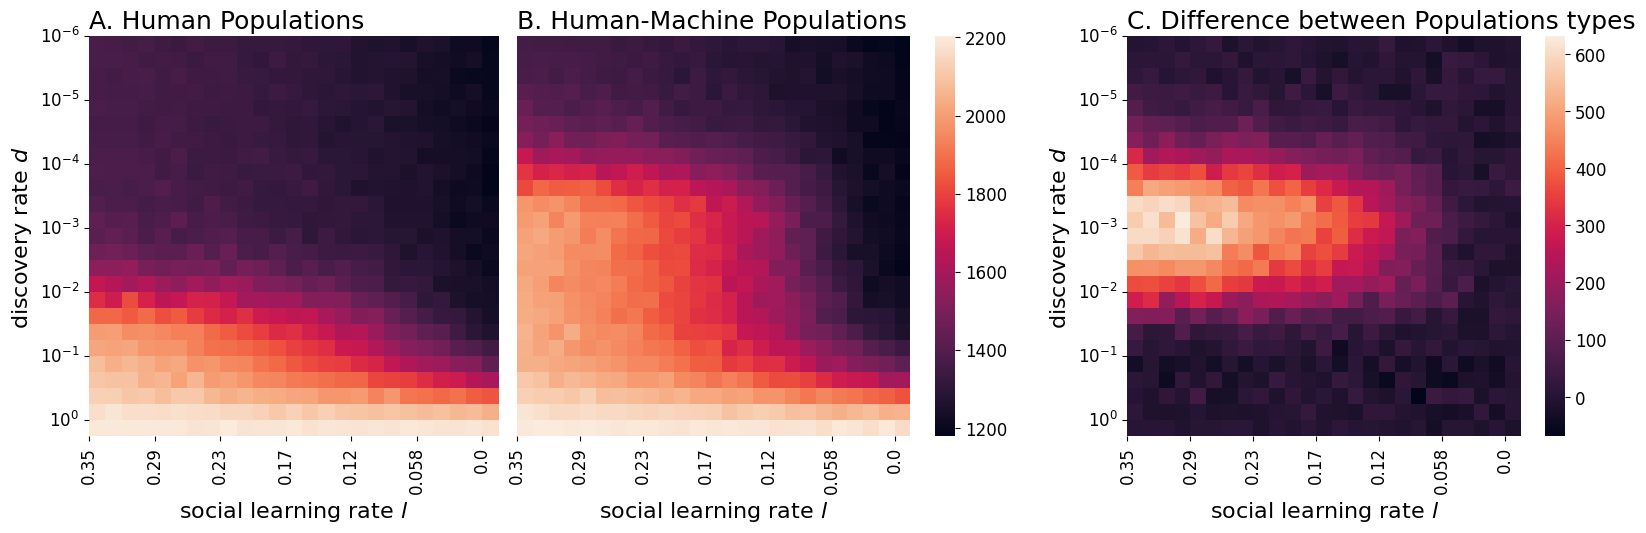

In [123]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a figure
fig = plt.figure(figsize=(17, 5))

gs = GridSpec(1, 4, width_ratios=[1, 1.2, 0.2, 1.2])

# Create subplots using the GridSpec
axes = [fig.add_subplot(gs[i]) for i in [0, 1, 3]]


m1 = reward_matrix.loc['human'].iloc[::-1].T
m2 = reward_matrix.loc['human-machine'].iloc[::-1].T
m3 = reward_diff_matrix.iloc[::-1].T


sns.heatmap(m1, ax=axes[0], cbar=False)
sns.heatmap(m2, ax=axes[1], cbar=True)
sns.heatmap(m3, ax=axes[2], cbar=True)

# set x tick labels
for i, ax in enumerate(axes):
    x_ticks = [(i, f"{x:.2}") for i, x in enumerate(m1.columns) if i % 4 == 0]
    ax.set_xticks([t[0] for t in x_ticks])
    ax.set_xticklabels([t[1] for t in x_ticks], size=12)
    if i != 1:
        ax.set_ylabel('discovery rate $d$', size=16)
        y_ticks = [(i, f"$10^{{{int(x):.0f}}}$") for i, x in enumerate(m1.index) if int(x) == x ]
        ax.set_yticks([t[0] for t in y_ticks])
        ax.set_yticklabels([t[1] for t in y_ticks], size=12)
    else:
        # remove y ticks and y label
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel('')

    ax.set_xlabel('social learning rate $l$', size=16)

axes[0].set_title('A. Human Populations', loc='left', size=18)
axes[1].set_title('B. Human-Machine Populations', loc='left', size=18)
axes[2].set_title('C. Difference between Populations types', loc='left', size=18)

# increase fonts on legend
for ax in axes:
    cbar = ax.collections[0].colorbar
    if cbar:
        cbar.ax.tick_params(labelsize=12)

plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1, wspace=0.05, hspace=0.3)


plt.savefig('plots/abm/heatmap_details.png', dpi=300)


[0, 4, 8, 12, 16, 20, 24]

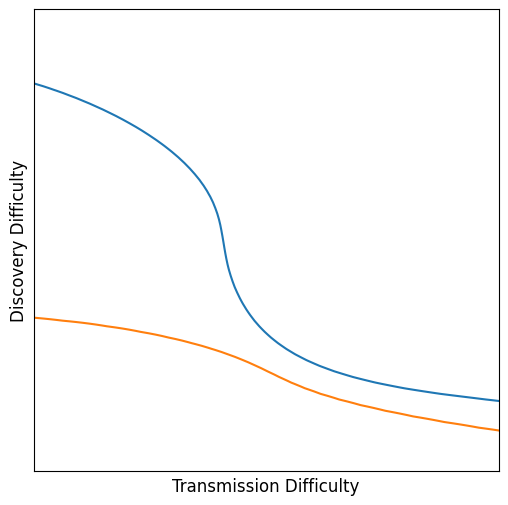

In [27]:

from matplotlib import pyplot as plt

plt.figure(figsize=(6, 6))


# back to long format
df = reward_matrix.stack().reset_index()

df_diff = reward_diff_matrix.stack().reset_index()

df_diff['condition'] = 'human-machine - human'

df = pd.concat([df, df_diff])

df.columns = ['type', 'l_optimal', 'd_optimal_log', 'reward']
df['learnability difficulty'] = - df['l_optimal']
df['discoverability difficulty'] = - df['d_optimal_log']
is_diff = df['type'] == 'human-machine - human'
df['weight'] = (df['reward'] > 1900)
df.loc[is_diff, 'weight'] = (df.loc[is_diff, 'reward'] > 500)

ax = sns.kdeplot(data=df, weights='weight', x='learnability difficulty', y='discoverability difficulty', fill=False, levels=2, hue='type', bw_adjust=1, hue_order=['human-machine', 'human'])

ax.set_xlim(-0.3, -0.1)
ax.set_ylim(0.5, 4.5)

# hide x and y ticks and tick labels
ax.set_xticks([])
ax.set_yticks([])

# hide legend
ax.get_legend().remove()

# add new axis labels
ax.set_xlabel('Transmission Difficulty', fontsize=12)
ax.set_ylabel('Discovery Difficulty', fontsize=12)


plt.savefig('plots/abm/heatmap.png', bbox_inches='tight', dpi=300)


In [88]:
len(m1.index)

25